In [2]:
import copy
import numpy as np
import networkx as nx
from networkx.generators.trees import NIL
import matplotlib.pyplot as plt
from random_word import RandomWords
from collections import defaultdict as ddict
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import seaborn as sns; sns.set()

In [3]:
%matplotlib notebook

In [4]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = list(G.neighbors(root)) 
    if parent != None:   #this should be removed for directed graphs.
        neighbors.remove(parent)  #if directed, then parent not in neighbors.
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

In [5]:
pwd

'/home/gmarconi/coding/python/poincare-embeddings/notebooks'

<IPython.core.display.Javascript object>


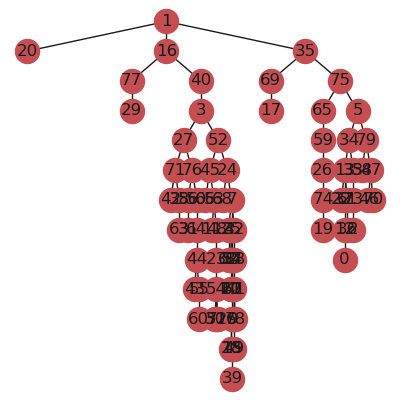

In [64]:
root_init=1
G = nx.random_tree(80, 777777)
plt.figure(figsize=(4,4))
pos = hierarchy_pos(G,root_init)
nx.draw(G, pos=pos, with_labels=True)

### Computes transitive closure
Converts the tree to a directed tree and changes the name of every node with a random word

<IPython.core.display.Javascript object>


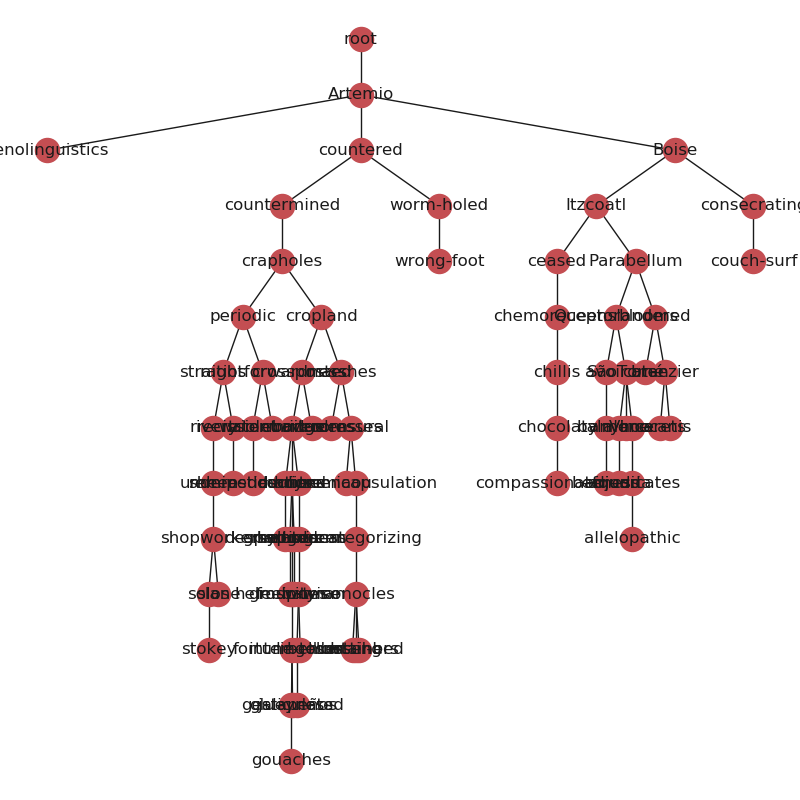

In [111]:
paths=[]
names={}
r = RandomWords()
words = [word.replace(" ", "") for word in r.get_random_words(limit=G.number_of_nodes())]
for target in G.nodes:
    for path in nx.all_simple_paths(G, source=root_init, target=target):
        paths.append(path)
#print(paths)
GD, root = nx.prefix_tree(paths)
GD.remove_node(NIL)
# names = ddict(r.get_random_word)
for idx, node in enumerate(GD.nodes):
    if node == root:
        continue
    names[node] = words[idx-1]
names[root] = 'root'
root = 'root'
GD = nx.relabel_nodes(GD, names, copy=False)
#plt.figure(figsize=(4,4))
#nx.draw(GD, with_labels=True)
U = nx.to_undirected(GD)
nodes  = [node[0] for node in U.adjacency()]
plt.figure(figsize=(8,8))
pos = hierarchy_pos(U,root)    
nx.draw(U, pos=pos, with_labels=True)

### Adds label attribute to ndoes and instances to leaves

In [112]:
start_nnodes = GD.number_of_nodes()
leaves_idx = GD.number_of_nodes()
gen_instances = True
max_child = 5
dim = 300

X = []
instances_list = []
nodes = [node for node in GD.nodes]
for node in nodes:
    if 'source' in GD.node[node]:
        del GD.node[node]['source']
        GD.add_node(node, label=str(node), feature=-1) 
    if gen_instances and len(list(GD.successors(node))) == 0 and (node != root):
        nchildren = np.random.randint(1, max_child+1)
        mean = np.zeros(dim)
        mean[min(dim-1, leaves_idx-start_nnodes)] = 10
        for child in range(nchildren):
            childname = str(node)+'_'+str(child)
            GD.add_node(childname, label=str(node), feature=(leaves_idx-start_nnodes))
            GD.add_edge(node, childname)
            instances_list.append(childname)
            leaves_idx += 1
            feature = np.random.multivariate_normal(mean=mean, cov=np.eye(mean.size))
            X.append(feature)
        print("Added %d leaves to node %s" % (nchildren, node))
X = np.asarray(X)
print("\nAdded %d leaves" % (leaves_idx - start_nnodes))
U = nx.to_undirected(GD)
nodes  = [node[0] for node in U.adjacency()]
plt.figure(figsize=(8,8))
pos = hierarchy_pos(U,'root')    
nx.draw(U, pos=pos, with_labels=True)

Added 2 leaves to node miaou
Added 3 leaves to node slane
Added 2 leaves to node underestimations
Added 5 leaves to node canis
Added 1 leaves to node gouaches
Added 2 leaves to node couch-surf
Added 4 leaves to node remipedes
Added 4 leaves to node stokey
Added 5 leaves to node allelopathic
Added 1 leaves to node water-bridge
Added 3 leaves to node xenolinguistics
Added 3 leaves to node overdresses
Added 4 leaves to node lingos
Added 5 leaves to node jalapeños
Added 1 leaves to node aquaria
Added 5 leaves to node helmswoman
Added 4 leaves to node netting
Added 4 leaves to node obtainers
Added 5 leaves to node carets
Added 2 leaves to node mussel-bed
Added 3 leaves to node group-wise
Added 4 leaves to node catan
Added 4 leaves to node desperateness
Added 5 leaves to node wrong-foot
Added 5 leaves to node gesticulated
Added 1 leaves to node befriend
Added 5 leaves to node compassionateness
Added 5 leaves to node alone
Added 1 leaves to node mailrooms

Added 98 leaves


In [114]:
U = nx.transitive_closure(GD)
G = nx.to_undirected(U)


(98, 98)


<IPython.core.display.Javascript object>


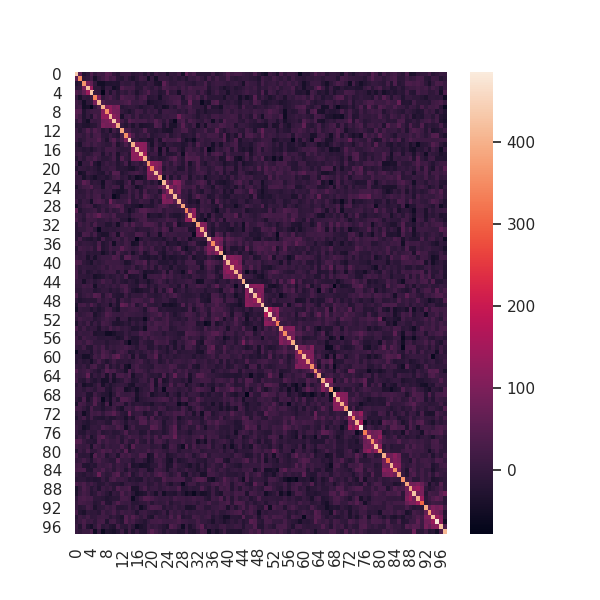

In [115]:
K = np.dot(X,X.T)
print(K.shape)
plt.figure(figsize=(6,6))
ax = sns.heatmap(K)
np.save("../data/synth_features.npy", X)

nx.write_weighted_edgelist(G, "../data/synth_instances.tsv", delimiter='\t')
nx.write_gpickle(G, '../data/synth_instances.p')